## Analyzing the World Happiness Data: Computing Linear Regressions among Variables
In this exercise, we will use the `sklearn` package to compute linear regressions among some of the variables in the World Happiness Report data set. 

### Step 1: Load & Process Data

Execute the next few code cells to load and reconfigure the data. Rather than examining the full dataset, we will just examine the data from 2015-2017, which we will store in a dataframe named ```df1517```.

In [705]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [706]:
dfraw = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name='Table2.1')

In [707]:
cols_to_include = ['country', 'year', 'Life Ladder', 
                   'Positive affect','Negative affect',
                   'Log GDP per capita', 'Social support',
                   'Healthy life expectancy at birth', 
                   'Freedom to make life choices', 
                   'Generosity', 'Perceptions of corruption']
renaming = {'Life Ladder': 'Happiness', 
            'Log GDP per capita': 'LogGDP', 
            'Social support': 'Support', 
            'Healthy life expectancy at birth': 'Life', 
            'Freedom to make life choices': 'Freedom', 
            'Perceptions of corruption': 'Corruption', 
            'Positive affect': 'Positive', 
            'Negative affect': 'Negative'}
df = dfraw[cols_to_include].rename(renaming, axis=1)
df1517 = df[df.year.isin(range(2015,2018))]
df1517 = df1517.dropna() # remove missing values
df1517.head()

,country,year,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption
7,Afghanistan,2015,3.98,0.55,0.34,7.47,0.53,51.69,0.39,0.09,0.88
8,Afghanistan,2016,4.22,0.56,0.35,7.46,0.56,52.02,0.52,0.06,0.79
9,Afghanistan,2017,2.66,0.50,0.37,7.46,0.49,52.34,0.43,-0.11,0.95
17,Albania,2015,4.61,0.69,0.35,9.30,0.64,68.69,0.70,-0.09,0.88
18,Albania,2016,4.51,0.68,0.32,9.34,0.64,68.87,0.73,-0.02,0.90


The World Happiness Report is generally interested in how self-reported Happiness (Life Ladder) is dependent on the variety of different factors that they measure (LogGDP, Support, Life, etc.).  The report carries out a detailed analysis explaining how much of each country's Happiness can be ascribed to each of the explanatory factors.  We will consider later the specific analysis carried out in the WHR, but start here with a simpler analysis.

 We'll start by importing the scikit-learn feature `linear_model`, the function `train_test_split` for splitting the data into training and test sets, and the metrics `mean_squared_error` and `r2_score` to evaluate our model.

In [708]:
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Step 2: Visualize Variables of Interest

Happiness and LogGDP in the WHR data are generally well correlated. Let's first examine a plot demonstrating this relationship. We will use the seaborn function reglplot() which will create a scatterplot of the data and overlay a line of best fit.

Execute the code cell below and examine the output.

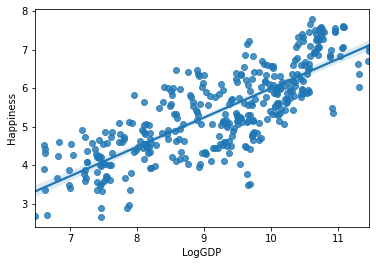

In [709]:
sns.regplot(x='LogGDP', y='Happiness', data=df1517);

### Step 3: Select Input (Feature) & Output (Label) Variables

Visually, the relationship between the two variables plotted above looks something like a line, albeit with a fair amount of jitter above and below that line. 

Linear regression is a method that estimates a relationship between two variables by fitting a line to data points relating those variables.  That is, given a set of data points relating two variables, linear regression creates a <b>model</b> of the data by assuming that the data relationship is well described by a straight line &mdash; more specifically, a straight line *is* the model of the data.  Given our assumption that a line is a good description of the data relationship, we need to identify what is the specific line that best fits our particular dataset.

Note: the input variables (features) are also referred to as independant varibables, and the output variable (label), is also referred to as the dependant variable.

Mathematically, a line relating an independent variable $x$ and a dependent variable $y$ is characterized by two parameters: the slope and the y-intercept.  Mathematically, we might write:

$$y = \beta_0 + \beta_1 x_1$$

where $\beta_1$ represents the slope (or weight) and $\beta_0$ represents the y-intercept (or bias).  The y-intercept is where the line crosses the y-axis (i.e., for $x = 0$), and the slope indicates how a change $\Delta x$ in the independent variable corresponds to a change $\Delta y$ in the dependent variable (the slope is given by $\beta_1 = \Delta_y/\Delta_x$).

In our case, we are interested in quantifying the relationship between Happiness and LogGDP, so we are interested in a specific model of the form:

$${\rm Happiness} = \beta_0 + \beta_1 * {\rm LogGDP}$$

Linear regression attempts to find the <b>best-fit line</b> that minimizes the least-squares error, that is, the difference between the actual data and the model prediction given by the equation above, summed over all data points. That is, linear regression produces a specific estimate for the model parameters $\beta_1$ and $\beta_0$ that does the best job of fitting the data points.

Visually, we can see that the weight of the general trend in the data is approximately equal to 1, because the y-axis increases by around 4 units (Happiness increasing from approximately 3 to 7) at the same time that the x-axis also increases by around 4 units (LogGDP going from 7 to 11).  It is harder to estimate the bias of the dataset, since at LogGDP=7, the data are far from the y-axis at $x = 0$.  You should recognize that some estimates for the model parameters $\beta_1$ and $\beta_0$ would do a poor job of describing the data.  If we chose the weight to be $\beta_1=100$, for example, then our model would be predicting a much more rapid rise than we see in the actual data.  Or if we chose a very large bias such as $\beta_0=1000$, the model predictions would lie far above the data.  But we don't need to rely on visual inspection, since we can use tools to estimate these model parameters numerically.  (This is part of a general process typically referred to as "parameter estimation" or "estimating parameters from data", but it should be recognized that parameter estimation always occurs within the context of some assumed model, such as the straight line we are using here.)

The method from scikit-learn that we will use specifically is called Ordinary Least Squares (OLS), which is the simplest of linear regression methods to estimate the model parameters that minimize the mean-squared error (MSE) between the actual data and the model predictions. The MSE is computed as:

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 $$

where $y_i$ is the $i$th value of the dependent variable (or label) and $\hat{y}_i$ is the regression model's predicted value. OLS chooses to minimize the MSE, which is referred to as a **loss function**. There are many possible loss functions for a regression problem and they will all give different results. The MSE is one of the simplest and most theoretically understood.

### Create labeled examples from our data set for the training phase:

We will create a <b>simple linear regression</b> model that finds the linear relationship between one feature and one label. We will use the <b>LogGDP</b> feature and the <b>Happiness</b> label. Our model will predict a Happiness value for a given LogGDP value.

Let's extract these variables from our data set to create labeled examples. The code cell below carries out the following steps:

* Extracts the LogGDP data from ```df1517``` and assign it to the variable ```x```. **It uses the ```to_frame()``` method on `x` to keep it as a pandas data frame instead of a series. This is important for the functions in scikit-learn.**
* Extracts the Happiness data from ```df1517``` and assign it to the variable ```y```
* Prints the values of `x` and `y`


Execute the code cell below and inspect the results. You will see that we have 380 labeled examples. Each example contains one feature (LogGDP) and one label (Happiness).

Our goal will be to fit a straight line relating the data in ```x``` to the data in ```y```.

In [710]:
x = df1517['LogGDP'].to_frame()
y = df1517['Happiness']

print(x)
print(y)


      LogGDP
7       7.47
8       7.46
9       7.46
17      9.30
18      9.34
...      ...
1548    8.20
1549    8.21
1559    7.56
1560    7.54
1561    7.54

[380 rows x 1 columns]
7      3.98
8      4.22
9      2.66
17     4.61
18     4.51
       ... 
1548   4.35
1549   3.93
1559   3.70
1560   3.74
1561   3.64
Name: Happiness, Length: 380, dtype: float64


### Step 4: Create Training & Test Data Sets

Now that we have specified examples, we will need to split them into a training set, that we will use to estimate the model parameters $\beta_1$ and $\beta_0$, and a test set, which we will use to understand the performance of our model on new data. 

Scikit-learn has a convenient function ```train_test_split()``` to do all this for us in a systematic way. 
We have imported this function above. As its name suggests, this function splits a dataset into separate training and testing sets.  The [online documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn-model-selection-train-test-split) indicates that it splits a dataset randomly, such that approximately 25% of the data winds up in the test set and the remaining 75% in the training set. You can also specify how much of the data set should be used as a test set using the parameter `test_size.`

Because ```train_test_split``` generates random splits of the input data, each time we call the function we will get a different split.  Sometimes it is useful, for the purposes of code development, to be able to get reproducible random numbers or random splits, which can then be relaxed once one wishes to generate statistics over many random runs.     With ```train_test_split```, this can be accomplished by using the ```random_state``` option; if specified with that state as an integer, then the <b>same</b> random split will be generated each time the function is called (until one changes the value of the integer).  This is known as providing a seed to the pseudo-random number generator that is used by ```train_test_split```.

In our case, we want to split ```x``` and ```y``` into coordinated test and train sets.

Run the code cell below to execute ```train_test_split``` with `x` and `y` as inputs, along with the parameters:
* `random_state=42` to ensure reproducible output each time the function is called
* `test-size=0.15`, which will randomly set aside 15% of the data to be used for testing. 

The function ```train_test_split``` will return four outputs that we have assigned to variables `x_train`, `x_test`, `y_train`, `y_test`. 


Note that `x_train` corresponds to features and `y_train` corresponds to labels. Likewise, `x_test` corresponds to the features we will use to test our model, and `y_test` corresponds to the labels that we will use to determine whether our model's predictions were accurate.

In [711]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

### Step 5: Fit a Linear Regression Model with the Training Set

Now that we've set up the basic elements of the data, let's carry out the regression.  scikit-learn works by creating objects that represent a model of the data: in this case, the model is linear regression, or a least-squares straight-line fit to the data.  The basic workflow is to first create a ```LinearRegression()``` object, and then to fit the model to the training data, which is the process by which the best-fit model parameters are estimated.  All model objects that one creates in scikit-learn possess a ```fit``` method that carries out the process of fitting (parameter estimation).

In the code cell below:

1. Use the ```linear_model.LinearRegression()``` function to create a model object, and assign the result to the variable ```model```.  You might find it useful to consult the [scikit-learn documentation on LinearRegression](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares).
2. Call the ```.fit()``` method on ```model``` to fit the model to the training data. The first argument should be ```x_train``` and the second ```y_train```.
3. Use the ```.predict()``` method on ```model``` with the argument ```x_test``` to use the fitted model to predict values for the testing data. Store the outcome in the variable ```y_pred```. We will compare these values to ```y_test``` later.

## Graded Cell


In [712]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)





## Self-Check

Run the cell below to test the correctness of your code above before submitting for grading.

In [713]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testRegression

try:
    print(testRegression(df1517, x, y, model, y_pred))
except Exception as e:
    print("Error!\n" + str(e))


Correct!


### Step 6: Evaluate the Model on the Test Set

Now that we have fit the model and made some predictions we will want to examine the model and its accuracy. 
* The weights $\beta$ are stored in numpy array ```model.coef_```. To access a particular weight, such as $\beta_1$, index into the array using the notation ```model.coef_[0]```. Note that we are using index notation, so the weight of feature1 is found in element 0 of the numpy array, the weight of feature 2 is found in element 1 of the numpy array, and so on.
* The bias $\beta_0$ is stored in ```model.intercept_```. 

To measure accuracy we will compute the RMSE (root mean square error) on the test set. 
Root Mean Square Error (RMSE) is the standard deviation of the errors.
Scikit-learn has a function ```mean_squared_error()``` which will compute the MSE between ```y_test``` and ```y_pred``` and then we just have to take the square root to obtain the RMSE. 

Finally, the coefficient of determination, also known as $R^2$, is a measure of the proportion of variability in the prediction that the model was able to make using the input data. An $R^2$ value of 1 is perfect and 0 implies no explainatory value. We can use ```r2_score()``` to compute it. Run the code below and examine the results.

In [714]:
# beta_1 (weight of feature LogGDP)
print('Model Summary\n\nbeta_1 =  ', model.coef_[0], '[ weight of feature LogGDP ]')
# beta_0 (beta_0)
print('beta_0 = ', model.intercept_, '[ bias ]')
# The mean squared error
print('\nModel Accuracy\n\nRMSE =   %.2f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print(' R^2 =   %.2f'
      % r2_score(y_test, y_pred))

Model Summary

beta_1 =   0.7743413443351356 [ weight of feature LogGDP ]
beta_0 =  -1.7506833275873177 [ bias ]

Model Accuracy

RMSE =   0.73
 R^2 =   0.56


In other words, using the data in the above, scikit-learn has identified that the best straight-line model fitting Happiness to LogGDP is:

$${\rm Happiness} = 0.7436 * {\rm LogGDP} - 1.4693$$

In the visual estimation of the slope we did above, we noted that the slope should be approximately equal to 1.  That turned out to be an over-estimate since the best-fit value is actually around 0.74, but it's not wildly off.

Examining the accuracy metrics, we have an RMSE of 0.71. This means that, on average, our predictions are off by 0.71 units. Since the happiness variable in our data set ranges between about 2.5 and 8, this result is not bad! To truly evaluate this we would want to compare this result to the RMSE when using another simpler model, such as using the mean value of the happiness variable as our prediction for every value of ```LogGDP```. 

The $R^2$ value of 0.62 implies that 62% of the variation in the ```Happiness``` variable was explained with the model by variation in ```LogGDP```. There is some subjectivity to interpreting what value is sufficient to justify the use of the model here, but let's just say that in the social sciences, it could also be a lot worse than 56%!

### Step 7: Visualize the Model

We can plot the data and the fit together using matplotlib. The code cell below:

* Uses ```plt.scatter()``` to plot the data ```x``` and ```y```. Set the point size s to a reasonable value to prevent overplotting of points on top of each other.
* Use ```plot.plot()``` to add a blue line to the plot using the values in ```x_test``` and ```y_pred```.
* Uses ```plt.xlabel()``` and ```plt.ylabel()``` to label the axes appropriately. 
* The plot should look similar to the ```sns.regplot()``` created earlier in step 2. 

Execute the code cell below and inspect the results.

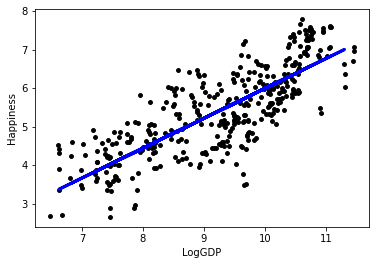

In [715]:
plt.scatter(x, y,  color='black',s=15);

plt.plot(x_test, y_pred, color='blue', linewidth=3);

plt.xlabel('LogGDP');
plt.ylabel('Happiness');


### Step 8: Create Labeled Examples for Multiple Linear Regression for the Training Phase

Simple linear regression finds the linear relationship between one input variable and one output variable, and multiple regression finds the linear relationship between multiple input variables and one output variable. 

We just performed a simple linear regression and found a relationship between the LogGDP and Happiness.

But we are not just interested in how Happiness depends on LogGDP, but how it relates to the full set of features collected in the WHR data: LogGDP, Support, Life, Freedom, Generosity, and Corruption.  To analyze this full set of dependencies, we can set up a multiple linear regression, which aims to fit a dependent variable (label) $y$ to a group of independent variables (features) $X$, by assuming that $y$ depends on each individual variable $X_i$ separately and in a linear manner.  Instead of a single weight $\beta_1$ as in the simple regression problem, there will now be a separate weight for each feature, i.e.:

$${\rm Happiness} =\beta_0 + [\beta_1 * {\rm LogGDP}] + [\beta_2 * {\rm Support}] + [\beta_3 * {\rm Life}] +[\beta_4 * {\rm Freedom}] + [\beta_5 * {\rm Generosity}] + [\beta_6 * {\rm Corruption}]$$

The code cell below creates the labeled examples for the multiple regression problem, similar as to what we did above. It peforms the following tasks:

* Assigns to the variable ```features``` the list of column labels for the features of interest
* Assigns to the variable ```y``` the Happiness data in the ```df1517``` dataframe
* Assigns to the variable ```x``` the data associated with the features in ```df1517```. **Since you are extracting multiple columns from ```df1517``` the result will be a data frame. You do not have to coerce it back to one like you did before using .to_frame()**
* Prints the value of ```x``` to verify that it has been constructed correctly


In [716]:
features = ['LogGDP', 'Support', 'Life', 'Freedom', 'Generosity', 'Corruption']

x = df1517[features]
y = df1517['Happiness']

print(x)


      LogGDP  Support  Life  Freedom  Generosity  Corruption
7       7.47     0.53 51.69     0.39        0.09        0.88
8       7.46     0.56 52.02     0.52        0.06        0.79
9       7.46     0.49 52.34     0.43       -0.11        0.95
17      9.30     0.64 68.69     0.70       -0.09        0.88
18      9.34     0.64 68.87     0.73       -0.02        0.90
...      ...      ...   ...      ...         ...         ...
1548    8.20     0.77 53.27     0.81        0.11        0.77
1549    8.21     0.74 53.80     0.82        0.13        0.74
1559    7.56     0.74 50.93     0.67       -0.09        0.81
1560    7.54     0.77 51.80     0.73       -0.07        0.72
1561    7.54     0.75 52.67     0.75       -0.07        0.75

[380 rows x 6 columns]


### Step 9: Create Training & Test Data Sets


The code cell below performs the train-test split on ```x``` and ```y``` using the same command as in step 4.

In [717]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

### Step 10: Fit a Multiple Linear Regression Model

Similar to what we did above, now let's create an OLS model for the multiple linear regression.  In the code cell below:

* Create an ```LinearRegression``` model to fit ```y``` to ```x``` and assign the result to the variable ```model2```
* Fit ```model2``` and assign the output to ```results2```
* Create a prediction vector ```y_pred``` using the ```x_test``` data as input to ```model2.predict()```


## Graded Cell

In [718]:
model2 = linear_model.LinearRegression()
model2.fit(x_train, y_train)
results2 = model2.fit
y_pred = model2.predict(x_test)


## Self-Check

Run the cell below to test the correctness of your code above before submitting for grading.

In [719]:
# Run this self-test cell to check your code; do not add code or delete code in this cell
from jn import testMultipleRegression

try:
    print(testMultipleRegression(df1517, x, y, model2, y_pred))
except Exception as e:
    print("Error!\n" + str(e))


Correct!


### Step 11: Evaluate the Model on the Test Set

Run the cell below to examine the model coefficients and metrics.

In [720]:
###### print('Model Summary:\n')

# Print bias (b_0)
print('Bias (y-intercept):')
print('beta_ 0 = ' , model2.intercept_ , '[ bias ]')

# Print weights
print('\nWeights:')
i = 0
for b in model2.coef_:
    print('beta_',i+1,'= ', b, ' [ weight of ', features[i],']')
    i += 1

# Print mean squared error
print('\nModel Accuracy\n\nRMSE =   %.2f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print(' R^2 =   %.2f'
      % r2_score(y_test, y_pred))

Bias (y-intercept):
beta_ 0 =  -2.424946074311782 [ bias ]

Weights:
beta_ 1 =  0.29508992828666314  [ weight of  LogGDP ]
beta_ 2 =  2.846499616214751  [ weight of  Support ]
beta_ 3 =  0.03215494406489183  [ weight of  Life ]
beta_ 4 =  1.5133471841693855  [ weight of  Freedom ]
beta_ 5 =  0.29026637012541634  [ weight of  Generosity ]
beta_ 6 =  -0.5175437220884864  [ weight of  Corruption ]

Model Accuracy

RMSE =   0.62
 R^2 =   0.68


### Step 12: Conclusions

Examine the output in the results summary.  Estimates of model parameters are now provided for all of the features, as well as the overall intercept.  Note that the estimates for the bias and the LogGDP weight are different than was the case in the simple regression.  That is typical, since multiple regression accounts for relationships between each independent and dependent variable once all the other data relationships are taken into account.

We can see from the summary results that the Support and Freedom variables have the largest weights, indicating that, on average, an increase in those variables corresponds to an increase in happiness. Corruption has a negative weight implying that, on average, a decrease in that feature corresponds to a decrease in happiness. These results fit with our common sense which is always important to verify.

We also see that our RMSE has decreased and our $R^2$ value has increased, both good indicators that adding more features has increased the accuracy and fit of the model (although it is important to note that adding variables will always increase $R^2$ and that the magnitude of the increase may differ depending on the variable)!

In carrying out a couple OLS analyses, we have just scratched the surface of the [functionality provided by scikit-learn](https://scikit-learn.org/stable/index.html). 


### Iterative Approach

You will recall that OLS is a non-iterative linear regression. If you have a regression problem that will benefit from using the iterative approach and the Stochastic Gradient Descent optimization algorithm, Scikit-learn makes it easy for you. You can simply use the `SGDRegressor` class in place of the `LinearRegression` class.

Essentially, you would replace the line ``model = linear_model.LinearRegression()`` with ``model = SGDRegressor(loss='squared_loss', max_iter=1000, tol=1e-3, learning_rate='constant')``, with the arguments of your choosing. You'll note that `SGDRegressor` allows you to specify which loss function to use, and the max number of iterations over your training data (epochs). It will also allow you to set hyperparameters, such as the `learning rate`. Once you train your model, you can evaluate the model's performance, and run the SGDRegressor again with a different hyperparameter argument.

You can consult the [scikit-learn documentation on SGDRegressor](https://scikit-learn.org/stable/modules/linear_model.html#stochastic-gradient-descent-sgd) for more information. 